# UNET SEGMENTATION

## [Original article](https://github.com/nikhilroxtomar/UNet-Segmentation-in-Keras-TensorFlow/blob/master/unet-segmentation.ipynb) of [Nikhil Tomar](https://github.com/nikhilroxtomar) on GitHub.

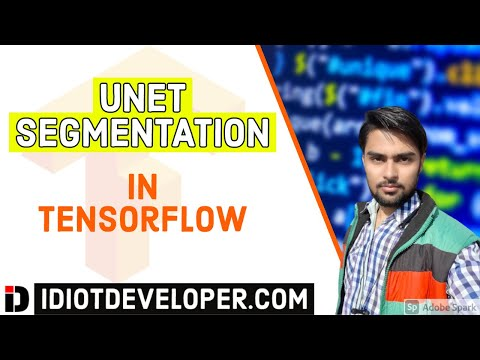

In [ ]:
#@title Unet segmentation in Keras TensorFlow
#@markdown Video explanation:
from IPython.display import YouTubeVideo
YouTubeVideo('M3EZS__Z_XE', width=600, height=400)


Paper Arxiv Link: <a href="https://arxiv.org/abs/1505.04597">U-Net: Convolutional Networks for Biomedical Image Segmentation</a>

<ul>
<li>UNet is a fully convolutional network(FCN) that does image segmentation. Its goal is to predict each pixel's class.</li>
 
<li>UNet is built upon the FCN and modified in a way that it yields better segmentation in medical imaging.</li>
</ul>

## 1.1 Architecture

<img src="https://raw.githubusercontent.com/foobar167/articles/master/Machine_Learning/data/2019.04.26_u-net-architecture.png"/>

<h3>UNet Architecture has 3 parts:</h3>
<ol>
    <li>The Contracting/Downsampling Path</li>
    <li>Bottleneck</li>
    <li>The Expanding/Upsampling Path</li>
</ol>

<h3>Downsampling Path: </h3> 
<ol>
    <li>It consists of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.</li> 
    <li>At each downsampling step we double the number of feature channels.</li>
</ol>

<h3>Upsampling Path: </h3> 
<ol>
     <li> Every  step  in  the  expansive  path  consists  of  an  upsampling  of  the feature map followed by a 2x2 convolution (“up-convolution”), a concatenation with the correspondingly feature  map  from  the  downsampling  path,  and  two  3x3  convolutions,  each  followed by a ReLU.</li>
</ol>

<h3> Skip Connection: </h3>
The skip connection from the downsampling path are concatenated with feature map during upsampling path. These skip connection provide local information to global information while upsampling.

<h3> Final Layer: </h3>
At the final layer a 1x1 convolution is used to map each feature vector to the desired number of classes.

## 1.2 Advantages
<h3> Advantages: </h3>
<ol>
    <li>The UNet combines the location information from the downsampling path to finally obtain a general information combining localisation and context, which is necessary to predict a good segmentation map.</li>
    <li>No Dense layer is used, so image sizes can be used.</li>
</ol>

## 1.3 Dataset
Link: <a href="https://www.kaggle.com/c/data-science-bowl-2018">Data Science Bowl 2018</a>
Find the nuclei in divergent images to advance medical discovery

## 1.4 Code

In [ ]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import natsort
from keras.preprocessing.image import ImageDataGenerator

## Seeding 
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Generator

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, image_ids, batch_size=8, image_size=512):
        self.ids = image_ids
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join('/content/drive/MyDrive/train/', id_name) + ".jpg"
        mask_path = os.path.join('/content/drive/MyDrive/label/', id_name)+".png"
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        ## Reading Masks
        mask = np.zeros((self.image_size, self.image_size, 1))
        _mask_image = cv2.imread(mask_path, -1)
        _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
        _mask_image = np.expand_dims(_mask_image, axis=-1)
        mask = np.maximum(mask, _mask_image)
            
        ## Normalizing 
        image = image/255.0
        mask = mask/255.0

        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)

        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Hyperparameters

In [ ]:
image_dir = '/content/drive/MyDrive/includeblock/train/'
label_dir = '/content/drive/MyDrive/includeblock/label/'
image_size = 512
epochs = 200
batch_size = 8

## Training Ids
image_fns = os.listdir(image_dir)
image_fns = natsort.natsorted(image_fns)

image_fns = [os.path.splitext(image_fns[i])[0] for i in range(len(image_fns))]
print(image_fns[:10])

## Validation Data Size
train_data_size = int(0.8*len(image_fns))
val_data_size = int(0.1*len(image_fns))
test_data_size = int(0.1*len(image_fns))

test_ids = image_fns[:test_data_size]
valid_ids = image_fns[test_data_size:test_data_size+val_data_size]
train_ids = image_fns[test_data_size+val_data_size:]

print(len(test_ids))
print(len(valid_ids))
print(len(train_ids))
print(len(image_fns))

FileNotFoundError: ignored

In [ ]:
gen = DataGen(train_ids, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

## Different Convolutional Blocks

In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

## UNet Model

In [ ]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0])  # 128 --> 64  512 --> 256
    c2, p2 = down_block(p1, f[1])  # 64  --> 32  256 --> 128
    c3, p3 = down_block(p2, f[2])  # 32  --> 16  128 --> 64
    c4, p4 = down_block(p3, f[3])  # 16  --> 8   64 --> 32
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3])  # 8  --> 16
    u2 = up_block(u1, c3, f[2])  # 16 --> 32
    u3 = up_block(u2, c2, f[1])  # 32 --> 64
    u4 = up_block(u3, c1, f[0])  # 64 --> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [ ]:
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

## Training the model

In [ ]:
train_gen = DataGen(train_ids, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps,
                    validation_steps=valid_steps, epochs=epochs)

In [ ]:
print(history.history.keys())

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print('\n')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Testing the model

In [ ]:
## Save the Weights
model.save_weights("UNetW.h5")

test_gen = DataGen(test_ids, image_size=image_size, batch_size=batch_size)

## Dataset for prediction
x, y = test_gen.__getitem__(2)
result = model.predict(x)
print(x.shape)

print("Evaluate on test data")
results = model.evaluate(test_gen, batch_size=8)

In [ ]:
for i in range(8):
  fig = plt.figure()
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  ax = fig.add_subplot(1,2,1)
  ax.imshow(np.reshape(y[i]*255, (image_size, image_size)), cmap="gray")

  ax = fig.add_subplot(1,2,2)
  ax.imshow(np.reshape(result[i]*255, (image_size, image_size)), cmap="gray")